# Analysis and Classification of The Bosphorus Database Dataset (Random Forest)

The analysis and classification of the Bosphorus Database Dataset project is to assign one of the six basic emotions (anger, disgust, fear, happy, sadness, and surprise) to a set of labeled facial landmark positions.


The Bosphorus Database Dataset emotion samples were provided as text or binary files, with either an ``.lm2`` (2D landmark file with the corresponding labels), ``.lm3`` (3D landmark file with the corresponding labels), or ``.bnt`` (coordinate file, both 3D coordinates and corresponding 2D image
coordinates) extension. In this notebook we'll use the ``.lm3`` files, which are parsed by the [lm3_parser.py](../parsers/lm3_parser.py) and transformed to a ``.csv`` file for convenience.

## Load Dataset

In [1]:
import pandas as pd

data_df = pd.read_csv(r'../../data/lm3.csv')

## Visualize Dataset Format and Number of Features

The dataset consists of a total of 453 samples and 78 features (26 landmarks, each in the x, y and z coordinates ``26*3=78``) and a label associative to it (79 features in total).

In [2]:
print('Total number of samples: \t%s' % data_df.shape[0])
print('Total number of features: \t%s' % len(data_df.columns.values))
data_df.head()

Total number of samples: 	453
Total number of features: 	79


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Outer left eyebrow-z,Middle left eyebrow-x,Middle left eyebrow-y,Middle left eyebrow-z,Inner left eyebrow-x,Inner left eyebrow-y,Inner left eyebrow-z,...,Lower lip outer middle-z,Chin middle-x,Chin middle-y,Chin middle-z,Left ear lobe-x,Left ear lobe-y,Left ear lobe-z,Right ear lobe-x,Right ear lobe-y,Right ear lobe-z
0,HAPPY,-93.462,21.740,-132.802,-78.982,38.091,-112.165,-43.466,37.160,-101.989,...,-92.978,-23.959,-105.822,-96.275,NaN,NaN,NaN,NaN,NaN,NaN
1,ANGER,-57.010,8.613,-117.176,-39.839,16.898,-95.527,-4.970,10.405,-86.952,...,-81.111,11.711,-118.613,-95.619,NaN,NaN,NaN,NaN,NaN,NaN
2,FEAR,-82.296,12.974,-133.700,-70.795,23.473,-119.858,-42.304,23.681,-104.009,...,-113.936,-16.601,-129.889,-122.292,NaN,NaN,NaN,NaN,NaN,NaN
3,SURPRISE,-96.492,19.760,-133.898,-90.431,40.303,-116.817,-54.582,37.653,-102.100,...,-94.403,-31.123,-119.315,-108.441,-104.538,-42.211,-168.265,42.448,-36.649,-163.079
4,DISGUST,-79.766,10.182,-146.890,-61.601,19.473,-128.063,-34.185,11.970,-131.882,...,-119.405,-12.169,-115.646,-129.492,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleansing

Unfortunately, some samples do not provide the value of a feature(s), which means that the same feature is also undefined across the 3 dimensions. The [lm3_parser.py](../parsers/lm3_parser.py) handles this use-case by simply setting the value of that feature across the 3 dimensions to ``NaN``.

#### Drop Features Where NaN Is Present

In [3]:
print('Total number of features before dropping NaN: \t%s' % len(data_df.columns.values))
data_df = data_df.dropna(axis=1, how='any')
print('Total number of features after dropping NaN: \t%s' % len(data_df.columns.values))
data_df.head()

Total number of features before dropping NaN: 	79
Total number of features after dropping NaN: 	58


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Outer left eyebrow-z,Middle left eyebrow-x,Middle left eyebrow-y,Middle left eyebrow-z,Inner left eyebrow-x,Inner left eyebrow-y,Inner left eyebrow-z,...,Left mouth corner-z,Upper lip outer middle-x,Upper lip outer middle-y,Upper lip outer middle-z,Right mouth corner-x,Right mouth corner-y,Right mouth corner-z,Lower lip outer middle-x,Lower lip outer middle-y,Lower lip outer middle-z
0,HAPPY,-93.462,21.740,-132.802,-78.982,38.091,-112.165,-43.466,37.160,-101.989,...,-114.580,-25.901,-48.047,-92.147,6.640,-48.994,-115.734,-26.681,-68.350,-92.978
1,ANGER,-57.010,8.613,-117.176,-39.839,16.898,-95.527,-4.970,10.405,-86.952,...,-94.121,13.197,-66.015,-82.066,42.331,-70.036,-98.870,12.439,-71.533,-81.111
2,FEAR,-82.296,12.974,-133.700,-70.795,23.473,-119.858,-42.304,23.681,-104.009,...,-124.049,-18.537,-58.730,-100.100,9.295,-65.177,-120.786,-17.513,-99.499,-113.936
3,SURPRISE,-96.492,19.760,-133.898,-90.431,40.303,-116.817,-54.582,37.653,-102.100,...,-111.567,-32.694,-57.166,-88.691,-8.728,-67.792,-108.059,-32.769,-86.531,-94.403
4,DISGUST,-79.766,10.182,-146.890,-61.601,19.473,-128.063,-34.185,11.970,-131.882,...,-140.888,-12.286,-61.197,-118.641,21.781,-67.838,-137.559,-13.072,-75.316,-119.405


## Data Normalization

Normalization refers to the process of standardizing the values of independent features of a dataset. Since many of the machine learning techniques use distance to compute the difference between two or more distinct samples, a feature within these samples that has a broad range of values will dominate the process. In order to avoid this, the range of all features are normalized so that each feature contributes approximately proportionately to the computation.

In [4]:
from sklearn.preprocessing import normalize

# Separate features from their labels
features = [x != 'Label' for x in data_df.columns.values]
all_values = data_df.loc[:, features].values
all_labels = data_df.loc[:,['Label']].values

# Scale values (mean = 0 and variance = 1)
all_values =  normalize(all_values, axis=1)

## Dimensionality Reduction

Furthermore, as the number of features of a dataset increases,  the concept of distance becomes less meaningful (which once again, does not help the set of machine learning techniques that rely on distance computations). This phenomenon is known as the curse of dimensionality and can be alleviated by using dimensionality reduction techniques.

#### Principal Component Analysis (PCA)

PCA is a statistical method that can be used to reduce the dimensionality of a dataset. It works by first finding the principal component that accounts for as much of the variance in the data features as possible. Next, each succeeding component in turn is selected such that it has the highest variance possible under the restriction that it is orthogonal to the previous principal components.

In [5]:
# Use PCA to reduce dimensionality
from sklearn.externals import joblib
from sklearn.decomposition import PCA

pca = PCA(n_components = 15, whiten = True)
principal_components = pca.fit_transform(all_values)
principal_components_df = pd.DataFrame(data = principal_components)

# Add the label to the dataframe with the principal components
pca_df = pd.concat([data_df[['Label']], principal_components_df], axis = 1)
pca_df.head()

,Label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,HAPPY,1.396112,-0.214718,0.878556,-0.845294,-0.138711,-0.588155,0.808054,-0.256718,-0.363856,1.208446,0.729657,0.349719,-0.342566,-0.501799,-0.109528
1,ANGER,1.308747,0.547219,-0.296638,-1.172256,-0.270100,-0.625748,0.639424,-1.044259,0.316894,-0.555884,1.240166,0.126557,-0.909168,0.556687,-0.198369
2,FEAR,1.398887,-0.146235,0.404232,-1.073505,0.083250,0.019337,0.711962,0.637936,-0.291027,0.922298,-0.324533,-0.400229,-1.438171,0.078434,-0.551312
3,SURPRISE,1.371978,-0.380862,0.793846,-0.710385,-0.511473,0.551610,0.892516,0.264207,0.066990,1.134885,0.615562,-0.893233,0.117497,-0.480003,-1.409293
4,DISGUST,1.435584,-0.040619,0.416296,-1.447781,0.150945,-0.088517,1.070733,-0.712058,-0.496400,-0.058548,0.376042,0.484996,-0.291085,0.842957,-0.838185


Visualize the PCA 2d projection

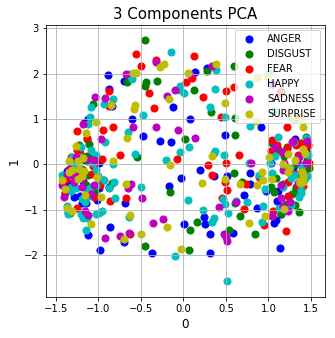

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
x_label = pca_df.columns.values[1]
y_label = pca_df.columns.values[2]
ax.set_xlabel(x_label, fontsize = 12)
ax.set_ylabel(y_label, fontsize = 12)
ax.set_title('3 Components PCA', fontsize = 15)

labels = np.unique(data_df.loc[:,['Label']].values)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for label, color in zip(labels, colors):
    indexes_to_keep = pca_df['Label'] == label
    ax.scatter(
        pca_df.loc[indexes_to_keep, x_label],
        pca_df.loc[indexes_to_keep, y_label],
        c = color,
        s = 50
    )
ax.legend(labels)
ax.grid()
plt.show()

#### t-Distributed Stochastic Neighbor Embedding  (t-SNE)

t-SNE is another technique that can be used to perform dimensionality reduction. It embeds high-dimensional data in a low-dimensional space by modeling each high-dimensional object by a two- or three-dimensional point such that objects that are alike are modeled by nearby points and dissimilar objects are modeled otherwise with a high probability.

In [7]:
from sklearn import manifold

tsne = manifold.TSNE(n_components = 15, init = 'pca', random_state = 0, method='exact')
tsne_components = tsne.fit_transform(all_values)
tsne_components_df = pd.DataFrame(data = tsne_components)

# Add the label to the dataframe with the t-SNE components
tsne_df = pd.concat([data_df[['Label']], tsne_components_df], axis = 1)
tsne_df.head()

,Label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,HAPPY,4.293549,-8.323322,0.899744,-1.359424,10.995966,15.203904,-5.857703,4.683652,3.910707,-14.145776,-6.016023,-2.218562,2.387118,4.649262,-1.620219
1,ANGER,4.684063,4.680794,-3.594029,5.318629,0.630863,2.003377,4.591975,0.188120,0.422289,-1.319835,-1.652932,-0.870756,0.425545,1.881013,-0.721671
2,FEAR,10.494254,-0.846628,5.079975,-13.234828,-6.002108,-0.198392,-2.592247,-9.106470,-0.132922,-9.276414,5.391991,2.248744,10.236415,-0.955271,2.091535
3,SURPRISE,4.706598,-1.532399,5.182418,-2.981781,12.709029,4.040305,-9.170864,-1.705256,0.764146,-5.500497,-5.233335,5.282393,1.922814,-0.877910,1.675902
4,DISGUST,2.749543,3.300130,-1.031897,13.030983,-8.006895,-1.417530,-1.843622,6.022197,0.006327,1.278148,-1.857150,1.041331,-2.170338,3.033186,-1.089584


Visualize the t-SNE 2d projection

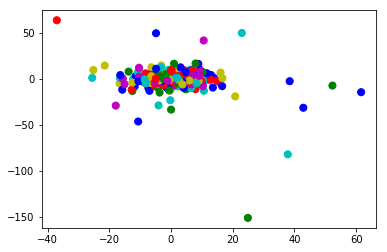

In [8]:
plt.scatter(tsne_components[:,0], tsne_components[:,1], c=colors, s=50)
plt.show()

## Class Imbalance

Class imbalance refers to the phenomenon where some classes (labels) of a dataset have more samples than others. This is a problem because the machine learning algorithms will tend to focus on the classification of the samples that are overrepresented while ignoring or misclassifying the underrepresented samples.

In [9]:
rows, cols = tsne_df.shape
print(tsne_df.groupby('Label').count()[0])

Label
ANGER        71
DISGUST      69
FEAR         70
HAPPY       106
SADNESS      66
SURPRISE     71
Name: 0, dtype: int64


From the output above we can see the dataset has a class imbalance problem. The emotion "HAPPY" has 106 samples, while "SADNESS" has only 66. We'll fix this issue by carefully selecting the number of samples we'll use for training the machine learning algorithms.

#### Data Split

We'll use the holdout method to create a training and test set with an ~80/20 split. As mentioned above, the dataset suffers from a class imbalance problem, and to solve this we'll randomly select the same number of samples per class to add to the training set (60 per class, 360 samples = ~80% of the dataset), and the remaining will be added to the test set (no sample is allowed to be in both sets at the same time).

In [10]:
def get_train_test_split(df):
    '''
    Split data into training and test sets
    '''
    # Shuffle data frame
    df = df.sample(frac=1)
    
    # Select same number of samples per class for train set, remaining go to test set
    num_of_train_inputs = int(rows * 0.8 / 6)
    train_df, test_df = (pd.DataFrame(columns=df.columns.values), pd.DataFrame(columns=df.columns.values))
    labels = np.unique(df.loc[:,['Label']].values)
    for label in labels:
        train_df = train_df.append(df.loc[df['Label'] == label][0:num_of_train_inputs], ignore_index=True)
        test_df = test_df.append(df.loc[df['Label'] == label][num_of_train_inputs:], ignore_index=True)

    # Shuffle data frames (because they were appended in an orderly per label fashion)
    train_df = train_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    
    # Split train and test datasets into labels/features
    train_values   = train_df.iloc[:,1:].values
    train_labels = train_df.iloc[:,:1].values.ravel()

    test_values   = test_df.iloc[:,1:].values
    test_labels = test_df.iloc[:,:1].values.ravel()
    
    return (train_values, train_labels, test_values, test_labels)

#### Confusion Matrix

Before working with the different machine learning methods which we'll use for classification, let's create a helper method which renders a confusion matrix of a specified model prediction output. A confusion matrix is a table often used to analyze the performance of a classifier on samples for which the true values are known (we'll use it to analyze the performance of the machine learning methods in the test set). Each row in the table represents the instances in an actual class while each column instances in a predicted class.

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, labels):
    '''
    Plot confusion matrix of the specified accuracies and labels
    '''
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    # Draw ticks
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    
    # Normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

## Methods

#### Random Forest

A random forest is an ensemble learning method for classification that works by creating multiple decision trees during training and predicting the class that is the mode of the classes of the individual decision trees.

Hyper-parameters:
- ``n_estimators``: The number of trees in the forest.
- ``criterion``: The function to measure the quality of a split.
- ``max_depth``: The maximum depth of the tree.

Create a Random Forest model using the PCA components:

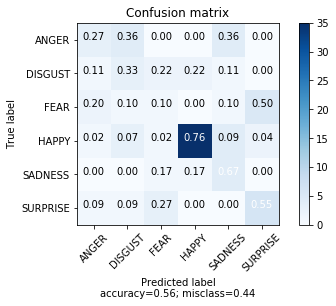

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Get train/test values and labels using the PCA components
train_values, train_labels, test_values, test_labels = get_train_test_split(pca_df)

random_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)
random_forest.fit(train_values, train_labels)
predicted_labels = random_forest.predict(test_values)
random_forest_pca_acc = accuracy_score(test_labels, predicted_labels)
random_forest_pca_cm = confusion_matrix(test_labels, predicted_labels)
plot_confusion_matrix(random_forest_pca_cm, labels)

Create a Random Forest model using the t-SNE components:

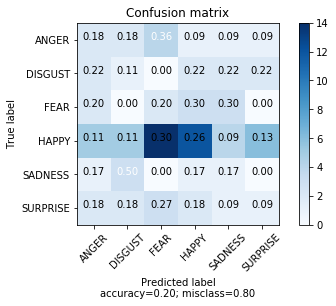

In [14]:
# Get train/test values and labels using the t-SNE components
train_values, train_labels, test_values, test_labels = get_train_test_split(tsne_df)

random_forest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)
random_forest.fit(train_values, train_labels)
predicted_labels = random_forest.predict(test_values)
random_forest_tsne_acc = accuracy_score(test_labels, predicted_labels)
random_forest_tsne_cm = confusion_matrix(test_labels, predicted_labels)
plot_confusion_matrix(random_forest_tsne_cm, labels)